# Introduction

Have you ever eaten steak before? Steak is one of the world's most popular dishes. Originiating from France, steak is meat that has been seared. Steaks can be cooked in different temperatures, ranging from rare steak to well-done steak. Some people have difficulty classifying the doneness of the steak, so this AI will help you determine the cook on your steak in the form of an image.

# Our steak doneness data labels.

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download steak-doneness

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 35% 9.00M/25.4M [00:00<00:00, 32.9MB/s]
100% 25.4M/25.4M [00:00<00:00, 73.0MB/s]


In [ ]:
!unzip steak-doneness.zip -d data

Archive:  steak-doneness.zip
replace data/01-rare/rare01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/01-rare/rare02.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: data/05-well-done/well61.jpg  
  inflating: data/05-well-done/well62.jpg  
  inflating: data/05-well-done/well63.jpg  
  inflating: data/05-well-done/well64.jpg  
  inflating: data/05-well-done/well65.jpg  
  inflating: data/05-well-done/well66.jpg  
  inflating: data/05-well-done/well67.jpg  
  inflating: data/05-well-done/well68.jpg  
  inflating: data/05-well-done/well69.jpg  
  inflating: data/05-well-done/well70.jpg  


# Extracting steak data from Food101 dataset.

In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [ ]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.8.2
/device:GPU:0


In [ ]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [ ]:
get_data_extract()

Dataset already exists


In [ ]:
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [ ]:
!kaggle kernels output theimgclist/multiclass-food-classification-using-tensorflow -p /path/to/dest

Kernel log downloaded to /path/to/dest/multiclass-food-classification-using-tensorflow.log 


In [ ]:
!zip -r /content/food-101/images/steak.zip /content/food-101/images/steak
files.download('/content/food-101/images/steak.zip')

updating: content/food-101/images/steak/ (stored 0%)
updating: content/food-101/images/steak/644777.jpg (deflated 0%)
updating: content/food-101/images/steak/2327701.jpg (deflated 0%)
updating: content/food-101/images/steak/3364420.jpg (deflated 1%)
updating: content/food-101/images/steak/1117936.jpg (deflated 1%)
updating: content/food-101/images/steak/2489716.jpg (deflated 1%)
updating: content/food-101/images/steak/3478318.jpg (deflated 1%)
updating: content/food-101/images/steak/240435.jpg (deflated 1%)
updating: content/food-101/images/steak/952407.jpg (deflated 0%)
updating: content/food-101/images/steak/401651.jpg (deflated 13%)
updating: content/food-101/images/steak/2198931.jpg (deflated 1%)
updating: content/food-101/images/steak/60633.jpg (deflated 0%)
updating: content/food-101/images/steak/2223787.jpg (deflated 9%)
updating: content/food-101/images/steak/3623556.jpg (deflated 0%)
updating: content/food-101/images/steak/3504515.jpg (deflated 0%)
updating: content/food-101/i

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training steak data.

In [ ]:
#pytorch ignite
!pip install -q --pre pytorch-ignite 

#fastai
!pip install -q fastbook 

#autogluon
!pip install --upgrade -q mxnet
!pip install -q autogluon

#huggingface and thai2transformers
!pip install -q --upgrade transformers datasets tokenizers #huggingface
!pip install -q emoji pythainlp sklearn-pycrfsuite seqeval #thai2transformers
!rm -r thai2transformers thai2transformers_parent #ลบ folder ที่ download มากรณีรัน cell นี้ซ้ำ
!git clone -b dev https://github.com/vistec-AI/thai2transformers/
!mv thai2transformers thai2transformers_parent
!mv thai2transformers_parent/thai2transformers .

exit()

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!head steak-train.txt 

steak/1000205
steak/100135
steak/101312
steak/1021458
steak/1032846
steak/10380
steak/1049459
steak/1053665
steak/1068516
steak/1068975


In [ ]:
!head steak-test.txt

steak/100274
steak/1012080
steak/1016217
steak/1064847
steak/1082384
steak/108310
steak/1094883
steak/1107549
steak/1118585
steak/1163050


In [ ]:
!pip install -q fastbook 
from fastbook import *

In [ ]:
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # GrandparentSplitter(valid_name='validation')
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [ ]:
get_image_files("data")

(#350) [Path('data/04-medium-well/mediumwell34.jpg'),Path('data/04-medium-well/mediumwell66.jpg'),Path('data/04-medium-well/mediumwell19.jpg'),Path('data/04-medium-well/mediumwell10.jpg'),Path('data/04-medium-well/mediumwell08.jpg'),Path('data/04-medium-well/mediumwell39.jpg'),Path('data/04-medium-well/mediumwell62.jpg'),Path('data/04-medium-well/mediumwell24.jpg'),Path('data/04-medium-well/mediumwell06.jpg'),Path('data/04-medium-well/mediumwell07.jpg')...]

In [ ]:
#get_image_files("food-101/images/steak")

In [ ]:
parent_label("data/test/000621fb3cbb32d8935728e48679680e.jpg")

'test'

In [ ]:
#dls = fields.dataloaders("food-101/images/steak")
dls = fields.dataloaders('data')

In [ ]:
dls.vocab

['01-rare', '02-medium-rare', '03-medium', '04-medium-well', '05-well-done']

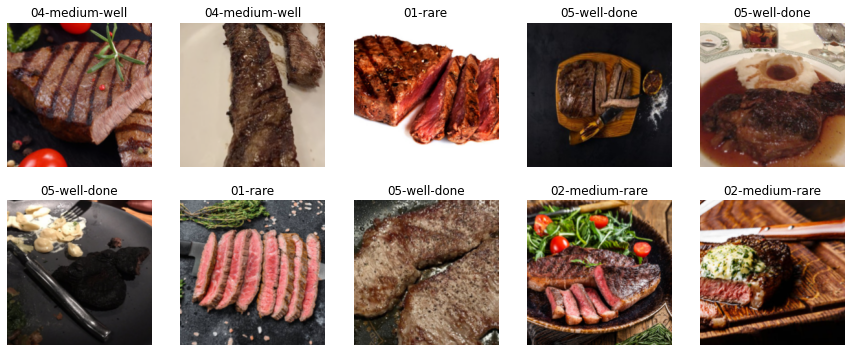

In [ ]:
dls.train.show_batch(max_n=10, nrows=2)

In [ ]:
learner = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])

SuggestedLRs(valley=0.0014454397605732083)

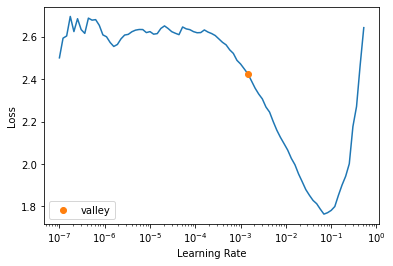

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(epochs=15, freeze_epochs=3, base_lr=0.0014454397605732083)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.048406,2.251306,0.414286,0.585714,00:04
1,0.033638,2.265386,0.428571,0.571429,00:04
2,0.051845,2.276263,0.414286,0.585714,00:04


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.051679,2.214022,0.414286,0.585714,00:04
1,0.061918,2.327580,0.428571,0.571429,00:04
2,0.057976,2.317093,0.414286,0.585714,00:04
3,0.049227,2.290405,0.414286,0.585714,00:04
4,0.044520,2.211659,0.400000,0.600000,00:04
5,0.054706,2.283953,0.428571,0.571429,00:04
6,0.052380,2.452278,0.442857,0.557143,00:04
7,0.050976,2.510276,0.428571,0.571429,00:04
8,0.052505,2.545468,0.442857,0.557143,00:04
9,0.052984,2.633528,0.442857,0.557143,00:04


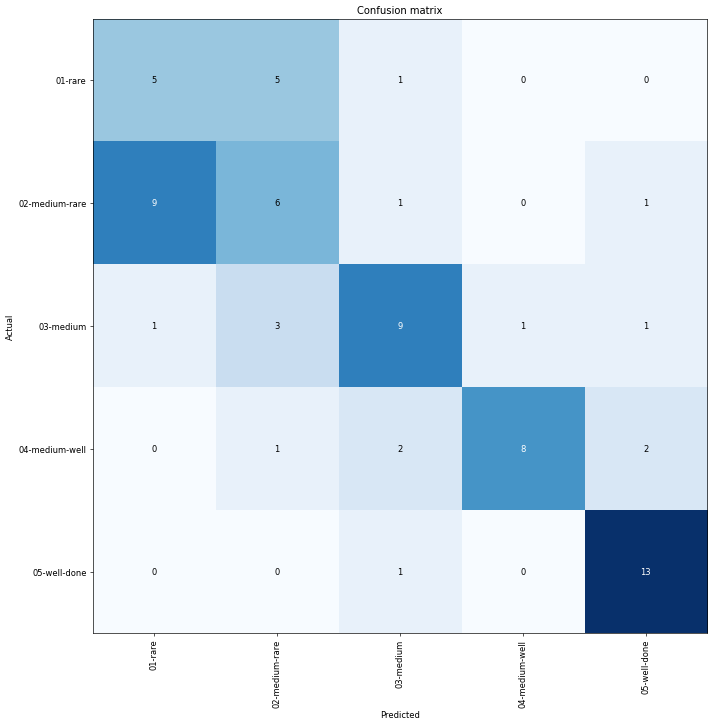

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

[('02-medium-rare', '01-rare', 9), ('01-rare', '02-medium-rare', 5)]

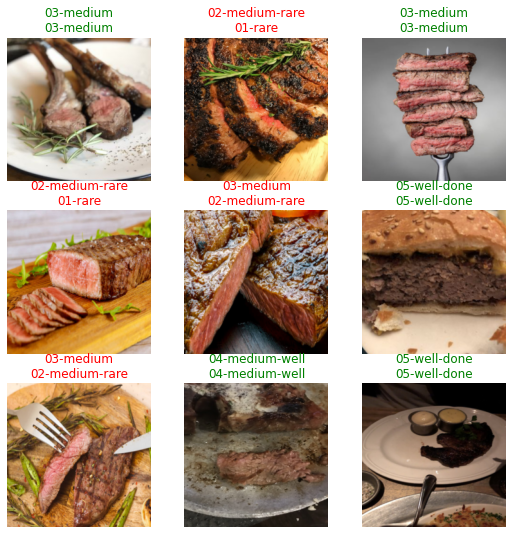

In [ ]:
learner.show_results(shuffle=True)

# Final Notes